# This notebook explores the variance in the imbalance of the gender imbalance

In [9]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import seaborn as sns
import pandas as pd
import datetime
import matplotlib.ticker as ticker
import pymc3 as pm

sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
#import covid19_inference as cov19
from header_plotting import *

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
# Load data
countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Italy', 'Slovakia',
       'Germany', 'Austria', 'Belgium', 'France', 'Portugal']
dl = covid19_soccer.dataloader.Dataloader_gender(countries=countries)#
dl._cases["IT"].loc["2021-06-24"] = np.nan

In [247]:
import datetime
import theano.tensor as tt

def make_nice(data_obs):
    no_cases = data_obs == 0
    cases = data_obs
    if len(data_obs.shape) > 1:

        for c in range(data_obs.shape[-1]):
            cases_obs_c = data_obs[..., c]
            # find short intervals of 0 entries and set to NaN
            no_cases_blob, n_blob = ndi.label(no_cases[..., c])
            for i in range(n_blob):
                if (no_cases_blob == (i + 1)).sum() < 10:
                    data_obs[no_cases_blob == i + 1, ..., c] = np.NaN

            # shift cases from weekends or such to the next day, where cases are reported
            if n_blob > 0:
                new_cases = 0
                update = False
                for i, cases_obs in enumerate(cases_obs_c):
                    new_cases += cases[i][..., c]
                    if np.isnan(cases_obs):
                        update = True
                    elif update:
                        cases[i][..., c] = new_cases
                        new_cases = 0
                        update = False
    return cases


def get_diff_in_imbalance(dl, ranges = None,time_var=True):
    """
    Get difference in imbalance from dataloader in one or multiple given
    time ranges. This is normalized to have a variance of 1
    
    Parameters
    ----------
    dl: dataloader
        
    ranges : list of list
        Ranges given
        default: [
            [2021-6-1, 2021-7-5] //Soccer
            [2021-4-25, 2021-5-30] //no-soccer
        ]
    
    Returns
    -------
    list of pd dataframes of imbalance values
    """
    if ranges is None:
        # Same number of days
        soccer = [
            datetime.datetime(2021,6,11),
            datetime.datetime(2021,7,16)
        ]
        no_soccer = [
            datetime.datetime(2021,6,10) - datetime.timedelta(days=35),
            datetime.datetime(2021,6,10),
        ]
        ranges = [
            soccer, no_soccer
        ]
        
    cases = dl._cases.xs(key="total",level="age_group") # there is only one age group
    cases = cases.loc[datetime.datetime(2021,1,1):datetime.datetime(2022,1,1),:]
    
    male_cases = cases.xs(key="male",level="gender")
    female_cases = cases.xs(key="female",level="gender")
    
    imbalance = ( male_cases / dl.population[0, :] - female_cases / dl.population[1, :] ) / ( female_cases / dl.population[1, :] + male_cases  / dl.population[0, :])
    

    if time_var:
        rolling_avg_imbalance = imbalance
        rolling_avg_imbalance = imbalance.rolling(4,min_periods=1).mean().diff(4) #4=gen interval

        #Normalize range to variance -1,1 by divind with standard deviation
        mi = np.min(np.array(ranges))
        ma = np.max(np.array(ranges))
        rolling_avg_imbalance = rolling_avg_imbalance.loc[mi:ma]

        #return rolling_avg_imbalance
        ret = [rolling_avg_imbalance.loc[r[0]:r[1]] for r in ranges]
    else:
            #Normalize range to variance -1,1 by divind with standard deviation
        mi = np.min(np.array(ranges))
        ma = np.max(np.array(ranges))
        imbalance = imbalance.rolling(4,min_periods=1).mean()
        imbalance = imbalance.loc[mi:ma]
        ret = [imbalance.loc[r[0]:r[1]] for r in ranges]
        
    return ret
    

def get_model_trace(soccer_data,no_soccer_data):
    """
    Get pymc3 model assuming same mean and same variance
    
    Parameters
    ----------
    soccer: np.array
        Soccer interval imbalance, shape: samples, country
    no_soccer_data: np.array
        None soccer interval imbalance, shape: samples, country    
    """
    numCountries = soccer_data.shape[1]
    with pm.Model() as model:
        
        """Hyperpriors
        """
        # or all countries
        imb1 = pm.Normal("mu1",0,2,shape=(numCountries,))
        imb1 = pm.Deterministic("imb_soccer",imb1)
       
        imb2 = pm.Normal("mu2",0,2,shape=(numCountries,))
        imb2 = pm.Deterministic("imb_no_soccer",imb2)
    
        # deviation of imbalance
        sigma1 = pm.HalfCauchy("sigma1",1,shape=(numCountries,))
        sigma2 = pm.HalfCauchy("sigma2",1,shape=(numCountries,))
        nu = pm.Exponential("nu_minus_one", 1 / 29.0) + 1

        soccer = pm.StudentT(
            "soccer",
            nu=nu,
            mu=imb1,
            sigma=sigma1,
            observed=soccer_data
        )
        
        nonSoccer = pm.StudentT(
            "no-soccer",
            nu=nu,
            mu=imb2,
            sigma=sigma2,
            observed=no_soccer_data
        )

        # Inference!
        # draw 3000 posterior samples using NUTS sampling
        trace = pm.sample(4000, tune=4000, return_inferencedata=True)
    return model, trace


/data.nst/smohr/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in no-soccer contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [no-soccer_missing, nu_minus_one, sigma2, sigma1, mu2, mu1]
INFO     [pymc3] NUTS: [no-soccer_missing, nu_minus_one, sigma2, sigma1, mu2, mu1]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 21 seconds.
INFO     [pymc3] Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 21 seconds.


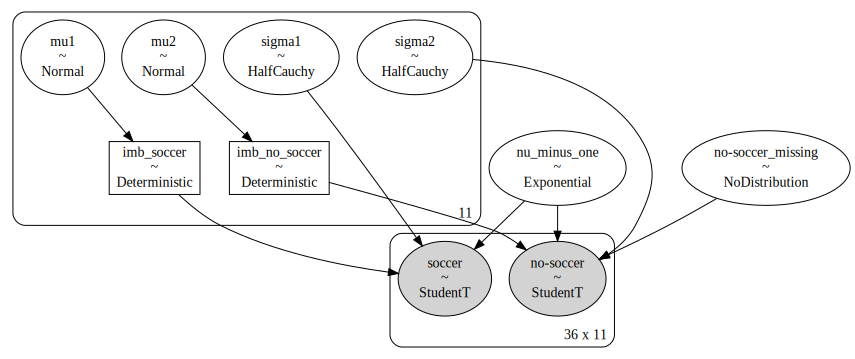

In [248]:
imb = get_diff_in_imbalance(dl,time_var=False)
model, trace = get_model_trace(imb[0].to_numpy(), imb[1].to_numpy())

pm.model_to_graphviz(model)

In [249]:
model_avg, trace_avg = get_model_trace(imb[0].to_numpy().flatten()[:,None],imb[1].to_numpy().flatten()[:,None])

/data.nst/smohr/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in no-soccer contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [no-soccer_missing, nu_minus_one, sigma2, sigma1, mu2, mu1]
INFO     [pymc3] NUTS: [no-soccer_missing, nu_minus_one, sigma2, sigma1, mu2, mu1]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 17 seconds.
INFO     [pymc3] Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 17 seconds.


## Create plot

<ipython-input-264-d0a4c254208c>:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(["0.0","0.05","0.10"])
<ipython-input-264-d0a4c254208c>:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(["0.0","0.1","0.2"])
<ipython-input-264-d0a4c254208c>:29: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color="orange", lw=0,),)
<ipython-input-264-d0a4c254208c>:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color="red", lw=0,),)


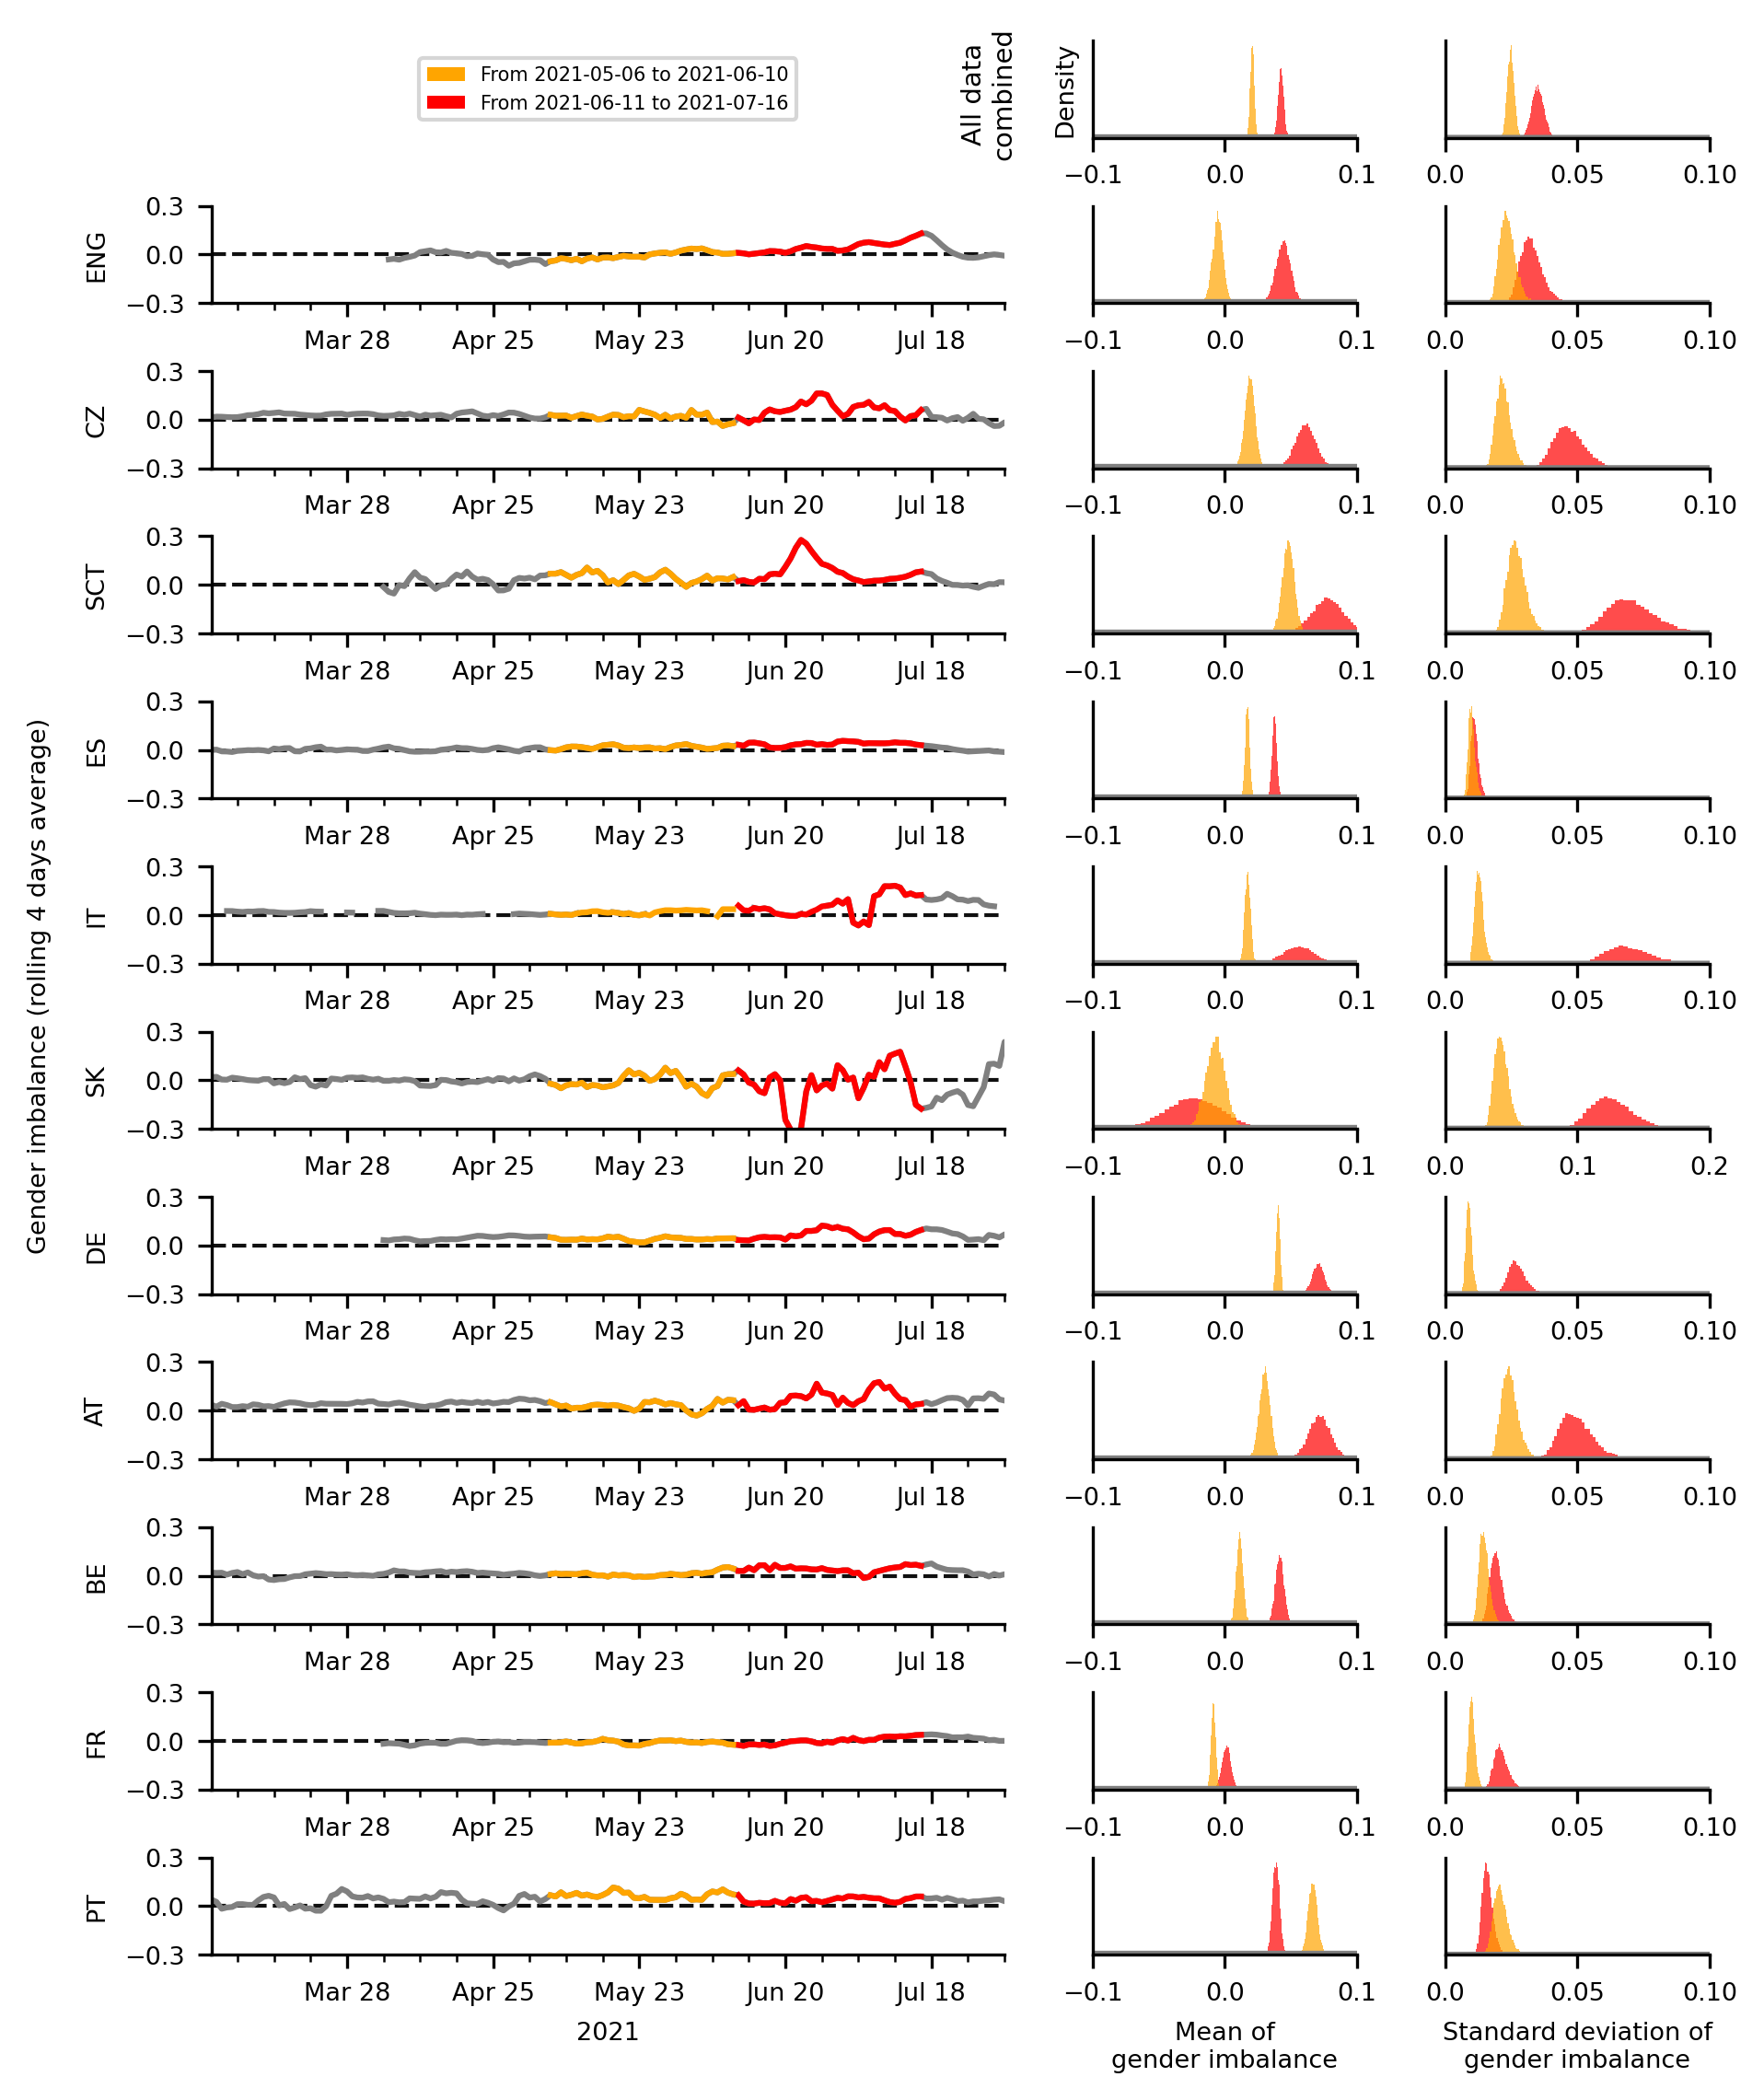

In [264]:
from matplotlib.patches import Patch
from covid19_soccer.plot.distributions import _plot_posterior, _plot_prior
from covid19_soccer.plot.timeseries import _uefa_range
from covid19_soccer.plot.utils import format_date_axis
from scipy.stats import norm
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m %d')


def legend(ax, loc="best", ranges=None, **kwargs):
    if ranges is None:
        # Same number of days
        soccer = [
            datetime.datetime(2021,6,11),
            datetime.datetime(2021,7,16)
        ]
        no_soccer = [
            datetime.datetime(2021,6,10) - datetime.timedelta(days=35),
            datetime.datetime(2021,6,10),
        ]
        ranges = [
            soccer, no_soccer
        ]
        
    lines = []
    labels = []
    lines.append(Patch([0], [0], color="orange", lw=0,),)
    labels.append(f'From {no_soccer[0].strftime("%Y-%m-%d")} to {no_soccer[1].strftime("%Y-%m-%d")}')
    lines.append(Patch([0], [0], color="red", lw=0,),)
    labels.append(f'From {soccer[0].strftime("%Y-%m-%d")} to {soccer[1].strftime("%Y-%m-%d")}')
    ax.legend(lines,labels,loc=loc, **kwargs)
    
soccer = [
    datetime.datetime(2021,6,11),
    datetime.datetime(2021,7,16)
]
no_soccer = [
    datetime.datetime(2021,6,10) - datetime.timedelta(days=35),
    datetime.datetime(2021,6,10),
]

cases = dl._cases.xs(key="total",level="age_group") # there is only one age group
cases = cases.loc[datetime.datetime(2021,1,1):datetime.datetime(2022,1,1),:]
male_cases = cases.xs(key="male",level="gender")
female_cases = cases.xs(key="female",level="gender")
imbalance = ( male_cases / dl.population[0, :] - female_cases / dl.population[1, :] ) / ( female_cases / dl.population[1, :] + male_cases  / dl.population[0, :])
imbalance = imbalance.rolling(4).mean()

fig, axes = plt.subplots(12,3,figsize=(7,1*9),gridspec_kw={"hspace":0.7,"width_ratios":[0.6,0.2,0.2]})


order = ['Avg.','GB-ENG', 'CZ', 'GB-SCT', 'ES', 'IT', 'SK',
       'DE', 'AT', 'BE', 'FR', 'PT']
order_to_index ={c:i for i,c in enumerate(imb[0].columns)}

order_to_index["Avg."] = -1

for i,c in enumerate(order):
    
    """ Timeseries
    """
    ax = axes[i,0]
    index = order_to_index[c]
    if index == -1: # AVG
        a= 10
    else:
        ax.plot(imbalance[c],c="gray")
        ax.plot(imb[0][c],c="red")
        ax.plot(imb[1][c],c="orange")
        ax.set_xlim(datetime.datetime(2021,3,2),datetime.datetime(2021,8,1))
        format_date_axis(ax)

    
    """ mu
    """
    # Posterior
    ax = axes[i,1]
    
    
    if index == -1: # AVG
        imb_soccer = trace_avg.posterior["imb_soccer"].to_numpy().flatten()
        imb_no_soccer = trace_avg.posterior["imb_no_soccer"].to_numpy().flatten()
    else:
        imb_soccer = trace.posterior["imb_soccer"].to_numpy()[:,:,index].flatten()
        imb_no_soccer = trace.posterior["imb_no_soccer"].to_numpy()[:,:,index].flatten()
    
    _plot_posterior(imb_soccer,ax=ax,color="red")
    _plot_posterior(imb_no_soccer,ax=ax,color="orange")

    #Prior
    ax.axhline(0.1,lw=2,c="gray")
    
    """ Sigma
    """
    # Posterior
    ax = axes[i,2]
    if index == -1: #AVG
        sigma_soccer = trace_avg.posterior["sigma1"].to_numpy().flatten()
        sigma_no_soccer = trace_avg.posterior["sigma2"].to_numpy().flatten()
    else:
        sigma_soccer = trace.posterior["sigma1"].to_numpy()[:,:,index].flatten()
        sigma_no_soccer = trace.posterior["sigma2"].to_numpy()[:,:,index].flatten()
    _plot_posterior(sigma_soccer,ax=ax,color="red")
    _plot_posterior(sigma_no_soccer,ax=ax,color="orange")
    
    #Prior
    l = norm.ppf(0.001,1,1)
    u = norm.ppf(0.999,1,1)
    x = np.linspace(l,u, 1000)
    ax.plot(x,norm.pdf(x,1,1),c="tab:gray")
    

for i,c in enumerate(order):
    ax = axes[i,:]
    for a in ax[1:]:
        a.set_yticks([])
    ax[1].set_xlim(-0.1,0.1)
    ax[2].set_xlim(0,0.1)
    ax[2].set_xticklabels(["0.0","0.05","0.10"])
   
    
    # Add label for country
    if i == 0:
        a = 5
    else:
        ax[0].axhline(0,ls="--",c="#101010",lw=1,zorder=-10)
        
    ax[0].set_ylabel(c.replace("GB-",""))
    ax[0].set_ylim(-0.3,0.3)
    ax[0].set_yticks([-0.3,0,0.3])
    if c == "SK":
        ax[2].set_xlim(0,0.2)
        ax[2].set_xticklabels(["0.0","0.1","0.2"])
    
    
fig.align_ylabels(axes)
axes[0,1].set_ylabel("Density")
fig.supylabel("Gender imbalance (rolling 4 days average)",x=0.03)
axes[-1,0].set_xlabel("2021")
axes[-1,1].set_xlabel("Mean of\ngender imbalance")
axes[-1,2].set_xlabel("Standard deviation of\ngender imbalance")
axes[0,0].axis('off')
axes[0,0].text(s="All data\ncombined",x=0.98,y=-0.4,ha="center",rotation=90,fontsize=7)
legend(axes[0,0],loc="center")
plt.show()
fig.savefig(f"../figures/SI/imbalance_analysis.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/imbalance_analysis.png", **save_kwargs)

In [205]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu Oct 13 2022

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.24.1

pymc3     : 3.11.2
numpy     : 1.20.3
seaborn   : 0.11.1
pandas    : 1.2.4
sys       : 3.8.10 | packaged by conda-forge | (default, May 11 2021, 07:01:05) 
[GCC 9.3.0]
theano    : 1.1.2
matplotlib: 3.5.1

Watermark: 2.3.1

